Looking at the internal representations of the RNN models in response to illusions

In [1]:
%reload_ext autoreload
%autoreload 2

import socket
import os
if socket.gethostname().startswith('ax'):
    path_prefix = '/mnt/smb/locker/miller-locker/users/Tahereh'
    path_codes = '/mnt/smb/locker/miller-locker/users/Tahereh/Codes/Perceptually_Aligned_Gradients/'
    os.chdir(path_codes)
    import sys
    sys.path.append(path_codes)
    sys.path.append('/mnt/smb/locker/miller-locker/users/Tahereh/Codes/Perceptually_Aligned_Gradients/Illusions')
elif socket.gethostname().startswith('demo'):
    path_prefix = '/home/tahereh/engram/users/Tahereh'
    path_codes = '/home/tahereh/engram/users/Tahereh/Codes/Public_Codes/Generative_Inference/'
    os.chdir(path_codes)
    import sys
    sys.path.append(path_codes)
    
print(os.getcwd())

## Settings of results 
fontsize_text = 25
color_text = 'mediumseagreen'
fontsize_text = 12


resultsdir = os.path.join(path_prefix, 'Research/Results/Generative_Inference')

# get the labels for imagenet
from Stimuli.load_stimuli import labels_imagenet
from Stimuli.load_stimuli import ImageLoader
from torchvision import transforms




/home/tahereh/engram/users/Tahereh/Codes/Public_Codes/Generative_Inference
Kernel running on local computer 'demo'.
['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark']


/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11/site-packages/robustness/train.py:24: UserWarning: Could not import amp.
  warnings.warn('Could not import amp.')


image names:  ('self', 'image_name', 'image_original', 'cmap')


In [ ]:
##

In [9]:
from Models.load_recurrent_models import get_model as get_model_CORNET
model = get_model_CORNET('S', pretrained=True)
model.eval()
model = model.to('cuda')

class args:
    model_arch = 'CORnet-S'
    dataset_model = 'imagenet'
    model_training = 'standard'
    epoch_chkpnt = 'full'
args = args()

figsave_dir = os.path.join(resultsdir, f'{args.model_arch}_{args.dataset_model}-{args.model_training}-{args.epoch_chkpnt}/')


image_name = 'NeonCircles' #'KanizsaSq' #
image, cmap = ImageLoader(args.dataset_model).load_image(image_name)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image = transform(image).unsqueeze(0).to('cuda')

/home/tahereh/engram/users/Tahereh/Codes/Public_Codes/Generative_Inference/Models/load_recurrent_models.py:208: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_data = tor

## PCN prednet
(main repo at Github/PCN-with-local-Recurrent-Processing)

In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from Models.prednet import *

import os

In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [17]:
# Create model
model_name = 'PredNetBpE'
models = {'PredNetBpE': PredNetBpE}
circles = 3  # Number of PCN circles
modelname = model_name + '_' + str(circles) + 'CLS'
print(f"=> creating model '{modelname}'")
model = models[model_name](num_classes=1000, cls=circles)

# Wrap model with DataParallel if using multiple GPUs
# if torch.cuda.device_count() > 1:
#     model = torch.nn.DataParallel(model)
model = model.to(device)
model.eval()
cudnn.benchmark = True

=> creating model 'PredNetBpE_3CLS'


In [45]:
# Load checkpoint
checkpoint_path = '../../Github/PCN-with-local-Recurrent-Processing/checkpoint_axon/checkpoint.pth.tar'
if os.path.isfile(checkpoint_path):
    print(f"=> loading checkpoint '{checkpoint_path}'")
    checkpoint = torch.load(checkpoint_path)
    
    # Load model state
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
        # Handle DataParallel state dict
        if 'module.' in list(state_dict.keys())[0]:
            state_dict = {k[7:]: v for k, v in state_dict.items()}
        
        # Remove DataParallel wrapper temporarily to load state dict
        if isinstance(model, torch.nn.DataParallel):
            model = model.module
        
        try:
            model.load_state_dict(state_dict)
            print("=> loaded model state")
        except Exception as e:
            print(f"Error loading state dict: {e}")
            raise RuntimeError("Failed to load state dict. Please ensure the model architecture matches the checkpoint.")
        
        # # Restore DataParallel wrapper if needed
        # if torch.cuda.device_count() > 1:
        #     model = torch.nn.DataParallel(model)
    
    # Print checkpoint information
    if 'epoch' in checkpoint:
        epoch_loaded = checkpoint['epoch']
        print(f"=> loaded epoch {checkpoint['epoch']}")
    if 'best_prec1' in checkpoint:
        print(f"=> loaded best_prec1 {checkpoint['best_prec1']}")
    if 'name' in checkpoint:
        print(f"=> loaded model name {checkpoint['name']}")
    model_id = f'PredNetBpE-imagenet-standard-{epoch_loaded}'
    resultsdir_PCN = os.path.join(resultsdir, model_id)
    if not os.path.exists(resultsdir_PCN):
        os.makedirs(resultsdir_PCN)
    print(f"Results directory: {resultsdir_PCN}")
else:
    print(f"=> no checkpoint found at '{checkpoint_path}'")
    raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")

=> loading checkpoint '../../Github/PCN-with-local-Recurrent-Processing/checkpoint_axon/checkpoint.pth.tar'


/tmp/ipykernel_1595044/3587475646.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


=> loaded model state
=> loaded epoch 29
=> loaded best_prec1 70.33200001220703
=> loaded model name PredNetBpE_3CLS
Results directory: /home/tahereh/engram/users/Tahereh/Research/Results/Generative_Inference/PredNetBpE-imagenet-standard-29


In [68]:
model = model.to(device)
model.eval()

dataset_model = 'imagenet'


image_name = 'RandomizedPhaseoval' #'FaceVase'#'FigureGroundUniform' #'FigureGroundLamme' #'NeonCircles' #'KanizsaSq' #'NeonCircles' #
image, cmap = ImageLoader(dataset_model).load_image(image_name)



In [26]:
model

PredNetBpE(
  (baseconv): features2(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (featBN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (PcConvs): ModuleList(
    (0): PcConvBp(
      (FFconv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (FBconv): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b0): ParameterList(  (0): Parameter containing: [torch.float32 of size 1x64x1x1 (cuda:0)])
      (relu): ReLU(inplace=True)
      (bypass): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): PcConvBp(
      (FFconv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (FBconv): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b0): ParameterList(  (0): Parameter containing: [torch.float32 o

In [69]:
# Define transformation
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])
image_tensor = transform(image).unsqueeze(0).cuda()
    
layer_idx = 3
# Get the target layer
target_layer = model.PcConvs[layer_idx]
cls_steps = model.cls

In [70]:
# Cell 1: Import the necessary libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image

# Cell 2: Define the activation recording function
def record_layer_activations(model, input_tensor, layer_idx):
    """
    Record activations of a specific PcConvBp layer during a forward pass.
    
    Args:
        model: The PredNet model
        input_tensor: Preprocessed input tensor
        layer_idx: Index of the PcConvBp layer to monitor
        
    Returns:
        List of activation tensors for each iteration
    """
    # Make sure model is in eval mode
    model.eval()
    
    # Get the layer to monitor
    target_layer = model.PcConvs[layer_idx]
    
    # Replace the forward method temporarily to record activations
    original_forward = target_layer.forward
    
    # List to store activations
    activations = []
    
    def custom_forward(self, x):
        # Initial feedforward pass
        y = self.relu(self.FFconv(x))
        activations.append(y.detach().clone())  # Initial activation
        
        # Iterations
        b0 = torch.relu(self.b0[0]+1.0).expand_as(y)
        for _ in range(self.cls):
            y = self.FFconv(self.relu(x - self.FBconv(y)))*b0 + y
            activations.append(y.detach().clone())  # Activation after iteration
        
        # Final bypass connection
        y = y + self.bypass(x)
        return y
    
    # Monkey patch the forward method
    target_layer.forward = custom_forward.__get__(target_layer, type(target_layer))
    
    # Run the forward pass to collect activations
    with torch.no_grad():
        _ = model(input_tensor)
    
    # Restore the original forward method
    target_layer.forward = original_forward
    
    return activations

# Cell 3: Define the visualization functions
def visualize_activations(activations, layer_idx):
    """
    Visualize activation maps across iterations.
    
    Args:
        activations: List of activation tensors
        layer_idx: Index of the layer for title
    """
    num_iterations = len(activations)
    num_channels = activations[0].shape[1]
    
    # Sample a few channels to visualize (e.g., first 4)
    channels_to_plot = min(4, num_channels)
    
    fig, axes = plt.subplots(channels_to_plot, num_iterations, figsize=(num_iterations*3, channels_to_plot*3))
    
    for i in range(channels_to_plot):
        for j in range(num_iterations):
            # Get activation map for channel i at iteration j
            activation = activations[j][0, i].cpu().numpy()
            
            # Handle case of single channel or iteration
            if channels_to_plot == 1 and num_iterations == 1:
                ax = axes
            elif channels_to_plot == 1:
                ax = axes[j]
            elif num_iterations == 1:
                ax = axes[i]
            else:
                ax = axes[i, j]
            
            im = ax.imshow(activation, cmap='viridis')
            ax.set_title(f"Ch {i}, Iter {j}")
            ax.axis('off')
            
            # Add colorbar
            plt.colorbar(im, ax=ax)
    
    plt.suptitle(f"Activations of Layer {layer_idx} over {num_iterations} iterations")
    plt.tight_layout()
    
    # Return the figure so we can display it in the notebook
    return fig




# Cell 4: Use your already loaded model and image to record and visualize activations
# Assuming you already have 'model' and 'image' (PIL Image) from previous cells

# Preprocess the image if needed
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
input_tensor = input_tensor.cuda()

# Specify which layer to analyze
layer_idx = 5  # Change this to the layer you want to analyze

# Record activations
activations = record_layer_activations(model, input_tensor, layer_idx)

# Print activation statistics
print(f"Number of activation maps: {len(activations)}")
for i, act in enumerate(activations):
    print(f"Iteration {i}: Shape={act.shape}, Mean={act.mean().item():.6f}, "
          f"Std={act.std().item():.6f}, Min={act.min().item():.6f}, Max={act.max().item():.6f}")

# Cell 5: Display visualizations
# Activation maps
# fig = visualize_activations(activations, layer_idx)
# plt.show()



# Cell 6: Visualize activation changes between iterations
def visualize_activation_changes(activations, layer_idx):
    """
    Visualize how activations change between iterations.
    
    Args:
        activations: List of activation tensors
        layer_idx: Index of the layer for title
    """
    if len(activations) <= 1:
        print("Need at least 2 iterations to visualize changes")
        return None
    
    num_iterations = len(activations) - 1  # Number of differences
    num_channels = activations[0].shape[1]
    
    # Sample a few channels to visualize
    channels_to_plot = min(4, num_channels)
    
    fig, axes = plt.subplots(channels_to_plot, num_iterations, figsize=(num_iterations*3, channels_to_plot*3))
    
    for i in range(channels_to_plot):
        for j in range(num_iterations):
            # Calculate difference between consecutive activations
            diff = activations[j+1][0, i] - activations[j][0, i]
            diff = diff.cpu().numpy()
            
            # Handle case of single channel or iteration
            if channels_to_plot == 1 and num_iterations == 1:
                ax = axes
            elif channels_to_plot == 1:
                ax = axes[j]
            elif num_iterations == 1:
                ax = axes[i]
            else:
                ax = axes[i, j]
            
            # Use a diverging colormap to show positive/negative changes
            vmax = abs(diff).max()
            im = ax.imshow(diff, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
            ax.set_title(f"Ch {i}, Iter {j} → {j+1}")
            ax.axis('off')
            
            # Add colorbar
            plt.colorbar(im, ax=ax)
    
    plt.suptitle(f"Activation Changes Between Iterations for Layer {layer_idx}")
    plt.tight_layout()
    
    return fig

# # Cell 7: Plot activation changes
# fig = visualize_activation_changes(activations, layer_idx)
# plt.show()



Number of activation maps: 4
Iteration 0: Shape=torch.Size([1, 256, 28, 28]), Mean=0.059495, Std=0.160147, Min=0.000000, Max=2.319995
Iteration 1: Shape=torch.Size([1, 256, 28, 28]), Mean=0.066974, Std=0.269259, Min=-1.521520, Max=2.777403
Iteration 2: Shape=torch.Size([1, 256, 28, 28]), Mean=0.072462, Std=0.286564, Min=-1.623047, Max=2.998075
Iteration 3: Shape=torch.Size([1, 256, 28, 28]), Mean=0.075807, Std=0.298985, Min=-1.761796, Max=3.199200


Feedforward activations: 4
Feedback activations: 3


/tmp/ipykernel_1595044/2972558273.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = plt.cm.get_cmap('hot_r')


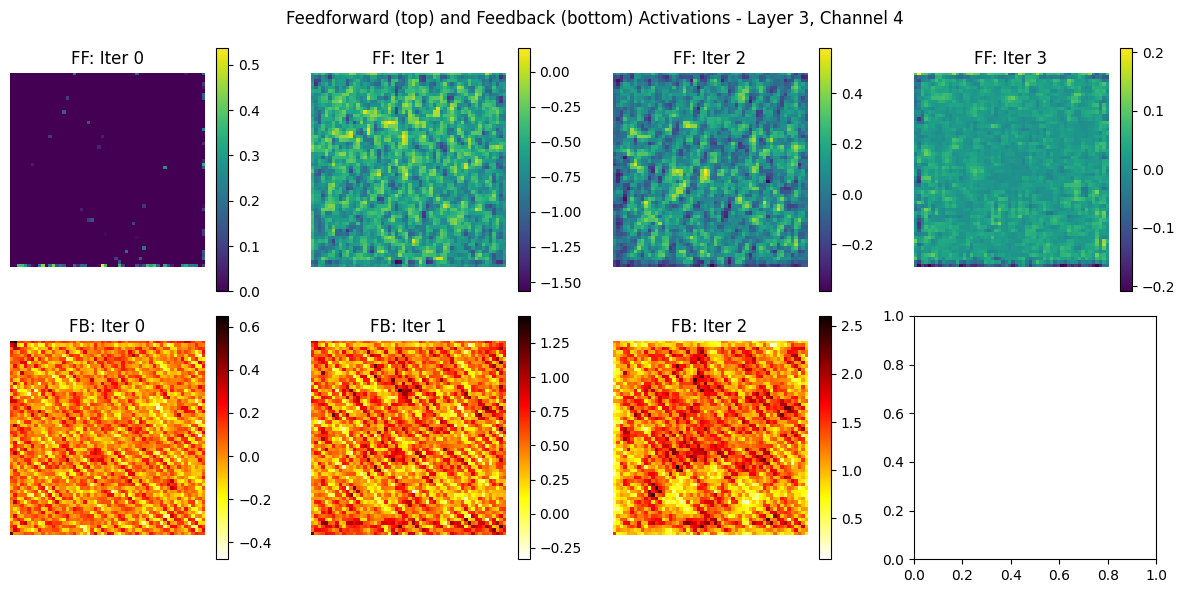

/tmp/ipykernel_1595044/2972558273.py:162: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = plt.cm.get_cmap('hot_r')


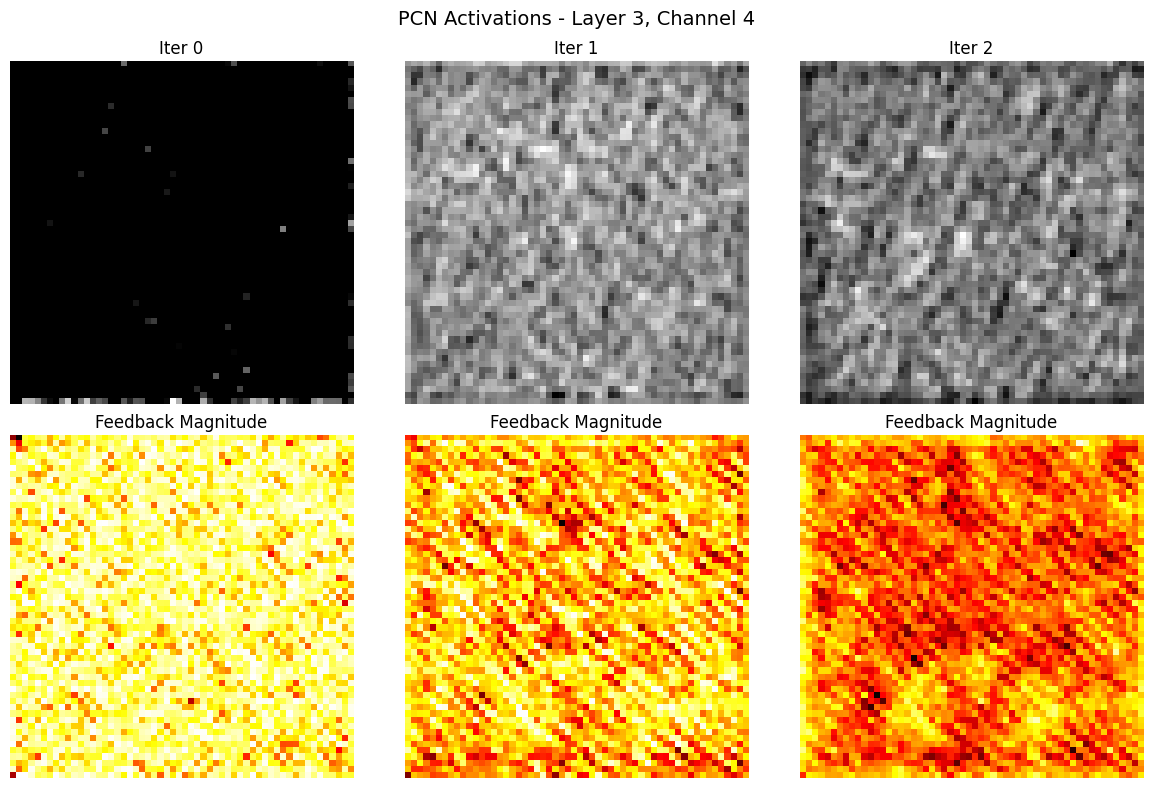

In [71]:
def record_ff_fb_activations(model, input_tensor, layer_idx):
    """
    Record both feedforward and feedback activations of a specific PcConvBp layer.
    
    Args:
        model: The PredNet model
        input_tensor: Preprocessed input tensor
        layer_idx: Index of the PcConvBp layer to monitor
        
    Returns:
        Dictionary containing feedforward and feedback activations at each iteration
    """
    # Make sure model is in eval mode
    model.eval()
    
    # Get the layer to monitor
    target_layer = model.PcConvs[layer_idx]
    
    # Replace the forward method temporarily to record activations
    original_forward = target_layer.forward
    
    # Dictionary to store activations
    activation_dict = {
        'feedforward': [],  # Output of FFconv
        'feedback': [],     # Output of FBconv
    }
    
    def custom_forward(self, x):
        # Initial feedforward pass
        ff_out = self.FFconv(x)
        y = self.relu(ff_out)
        activation_dict['feedforward'].append(ff_out.detach().clone())
        
        # Iterations
        b0 = torch.relu(self.b0[0]+1.0).expand_as(y)
        for _ in range(self.cls):
            # Feedback projection
            fb_out = self.FBconv(y)
            activation_dict['feedback'].append(fb_out.detach().clone())
            
            # Feedforward of error
            ff_out = self.FFconv(self.relu(x - fb_out))
            activation_dict['feedforward'].append(ff_out.detach().clone())
            
            # Updated prediction
            y = ff_out*b0 + y
        
        # Final bypass connection
        y = y + self.bypass(x)
        return y
    
    # Monkey patch the forward method
    target_layer.forward = custom_forward.__get__(target_layer, type(target_layer))
    
    # Run the forward pass to collect activations
    with torch.no_grad():
        _ = model(input_tensor)
    
    # Restore the original forward method
    target_layer.forward = original_forward
    
    return activation_dict

def visualize_ff_fb_similar_to_gen_inf(activation_dict, layer_idx, num_iterations_to_show=5, channel_idx=0):
    """
    Visualize feedforward and feedback activations similar to generative inference layout.
    
    Args:
        activation_dict: Dictionary of activation tensors
        layer_idx: Index of the layer for title
        num_iterations_to_show: Number of iterations to display (should be <= actual iterations)
        channel_idx: Channel to visualize
    """
    # Get the data for feedforward and feedback
    ff_activations = activation_dict['feedforward']
    fb_activations = activation_dict['feedback']
    
    # Limit to requested number of iterations
    iterations = min(num_iterations_to_show, len(fb_activations) + 1)
    
    # Create a figure with 2 rows (feedforward and feedback)
    fig, axes = plt.subplots(2, iterations, figsize=(iterations*3, 6))
    
    # Plot feedforward activations in the top row
    for i in range(iterations):
        if i < len(ff_activations):
            # Get activation map for the specified channel
            ff_act = ff_activations[i][0, channel_idx].cpu().numpy()
            
            # Plot
            im = axes[0, i].imshow(ff_act, cmap='viridis')
            axes[0, i].set_title(f"FF: Iter {i}")
            axes[0, i].axis('off')
            
            # Add colorbar
            plt.colorbar(im, ax=axes[0, i])
    
    # Plot feedback activations in the bottom row (offset by one iteration)
    for i in range(iterations):
        if i < len(fb_activations):
            # Get activation map for the specified channel
            fb_act = fb_activations[i][0, channel_idx].cpu().numpy()
            
            # Create a custom colormap similar to the red-yellow gradient in your generative inference plot
            # Note: You can customize this colormap to match your generative inference exactly
            custom_cmap = plt.cm.get_cmap('hot_r')
            
            # Plot
            im = axes[1, i].imshow(fb_act, cmap=custom_cmap)
            axes[1, i].set_title(f"FB: Iter {i}")
            axes[1, i].axis('off')
            
            # Add colorbar
            plt.colorbar(im, ax=axes[1, i])
    
    plt.suptitle(f"Feedforward (top) and Feedback (bottom) Activations - Layer {layer_idx}, Channel {channel_idx}")
    plt.tight_layout()
    
    return fig

def generate_gradient_magnitude_visualization(activation_dict, layer_idx, num_iterations_to_show=5, channel_idx=0):
    """
    Generate gradient magnitude visualization similar to your generative inference example.
    
    Args:
        activation_dict: Dictionary of activation tensors
        layer_idx: Index of the layer for title
        num_iterations_to_show: Number of iterations to display
        channel_idx: Channel to visualize
    """
    # Get feedback activations
    fb_activations = activation_dict['feedback']
    iterations = min(num_iterations_to_show, len(fb_activations))
    
    # Create a figure with two rows - class envelope (feedforward) and gradient magnitude (feedback)
    fig, axes = plt.subplots(2, iterations, figsize=(iterations*4, 8))
    
    # Plot feedforward activations (similar to "class envelope")
    for i in range(iterations):
        ff_idx = min(i, len(activation_dict['feedforward'])-1)
        ff_act = activation_dict['feedforward'][ff_idx][0, channel_idx].cpu().numpy()
        
        # Normalize for better visualization
        ff_act = (ff_act - ff_act.min()) / (ff_act.max() - ff_act.min() + 1e-8)
        
        # Use grayscale for top row to mimic your example
        im = axes[0, i].imshow(ff_act, cmap='gray')
        axes[0, i].set_title(f"Iter {i}")
        axes[0, i].axis('off')
    
    # Plot feedback activations as "gradient magnitude"
    for i in range(iterations):
        if i < len(fb_activations):
            # Get activation map
            fb_act = fb_activations[i][0, channel_idx].cpu().numpy()
            
            # Get gradient magnitude (using absolute value for simplicity)
            feedback_mag = np.abs(fb_act)
            
            # Create a custom hot colormap for gradient visualization
            # Modified to match your red-yellow gradient more closely
            custom_cmap = plt.cm.get_cmap('hot_r')
            
            # Plot with custom colormap
            im = axes[1, i].imshow(feedback_mag, cmap=custom_cmap, vmin=0, vmax=feedback_mag.max())
            axes[1, i].set_title("Feedback Magnitude")
            axes[1, i].axis('off')
            
            # Add colorbar with manually set ticks to match your example
            # cbar = plt.colorbar(im, ax=axes[1, i])
            # max_val = feedback_mag.max()
            # cbar.set_ticks([0, 0.2*max_val, 0.4*max_val, 0.6*max_val, 0.8*max_val, max_val])
            # cbar.set_ticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
    
    plt.suptitle(f"PCN Activations - Layer {layer_idx}, Channel {channel_idx}", fontsize=14)
    plt.tight_layout()
    
    return fig

# Record both feedforward and feedback activations
layer_idx = 3  # Your target layer
activation_dict = record_ff_fb_activations(model, input_tensor, layer_idx)

# Print statistics about recorded activations
print(f"Feedforward activations: {len(activation_dict['feedforward'])}")
print(f"Feedback activations: {len(activation_dict['feedback'])}")

# Choose a channel to visualize (you can change this)
channel_idx = 4

# Basic two-row visualization
fig1 = visualize_ff_fb_similar_to_gen_inf(activation_dict, layer_idx, channel_idx=channel_idx)
fig1.savefig(os.path.join(resultsdir_PCN, f'{image_name}_{model_id}_PcConvs{layer_idx}_channel{channel_idx}.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Visualization similar to your generative inference example
fig2 = generate_gradient_magnitude_visualization(activation_dict, layer_idx, channel_idx=channel_idx)
fig2.savefig(os.path.join(resultsdir_PCN, f'{image_name}_{model_id}_PcConvs{layer_idx}_channel{channel_idx}_withfeedback_magnitude.pdf'), bbox_inches='tight', dpi=300)

plt.show()
